In [1]:
import pandas as pd
import plotly.express as px
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt

In [3]:
import tqdm.notebook as tqdm

In [4]:
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [5]:
import torch

In [6]:
import numpy as np

In [7]:
import re
import random
random.seed(42)

## 0. Context

The aim of the notebook is to replicate NNLM (`Neural Network Language Model`) by Bengio et al. 

**Objective**

1. Nth word, given n-1 words in sequence
2. Understand how word feature looks like for similar words like cat, dog


**Assumption**

1. Word prediction is happening within a sentence, this implies `.` acts as `End of Sentence` Token

## 1. Downloading Data

In [8]:
from nltk.corpus import brown

## 2. Creating Data Set from `brown` corpus


> Total Sentences is 57340, and each sentences will be taken as stand alone unit for creating input-target pair 

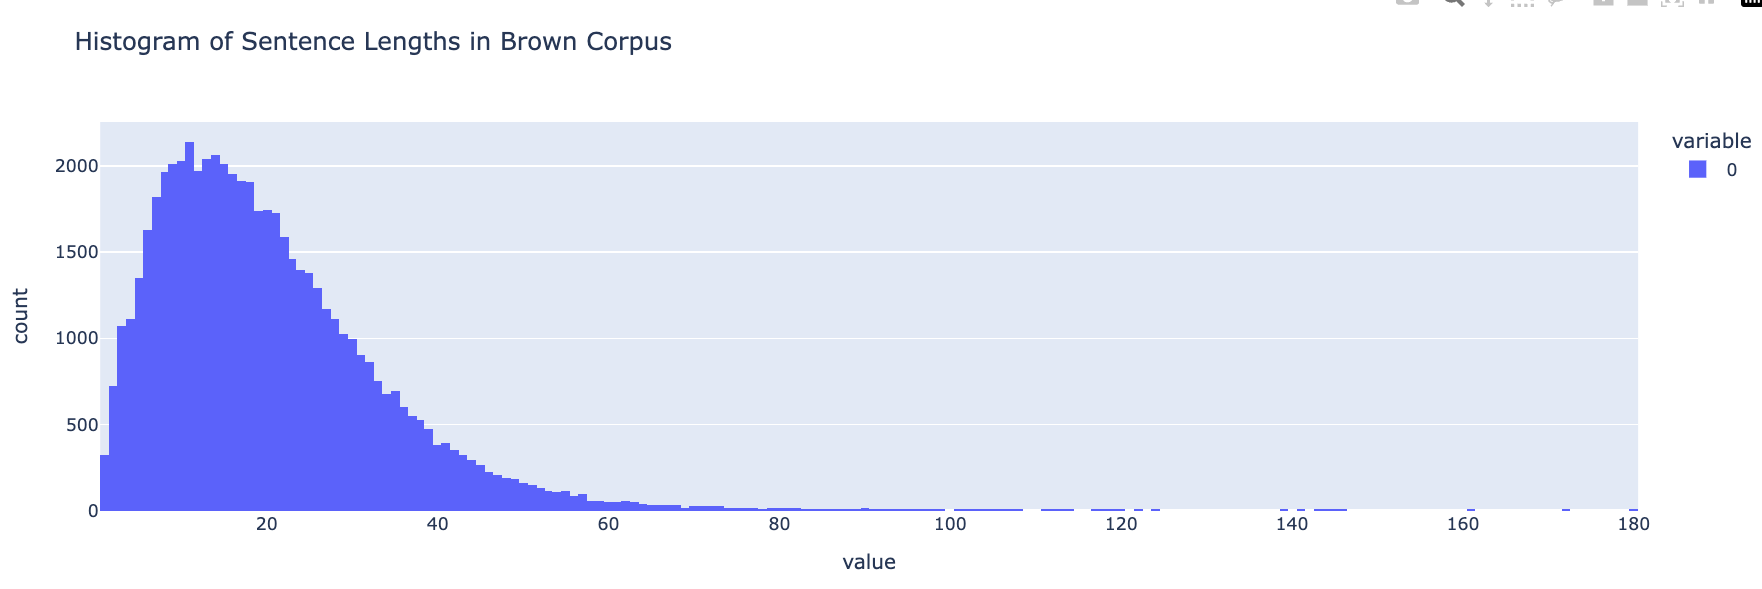

input context block : 4

Minimum sentence length: 5

### 2.1 Creating sentence split for train, test, validatiom

In [9]:
sentence_list_selected = [sent for sent in brown.sents() if len(sent) > 4]

In [10]:
len(sentence_list_selected)

54105

In [11]:
random.shuffle(sentence_list_selected)
n1 = int(0.8 * len(sentence_list_selected))
n2 = int(0.9 *len(sentence_list_selected))

train_sentences = sentence_list_selected[:n1]
validation_sentences = sentence_list_selected[n1:n2]
test_sentences = sentence_list_selected[n2:]

### 2.1. Creating Train, Validation & Test Corpus

No Special Preprocessing is being applied except from case folding

In [12]:
training_corpus = {}

for sent in train_sentences:
    for word in sent:
        training_corpus[word.lower()] = training_corpus.get(word.lower(),0) + 1

In [13]:
print(f"Vocabulary size in Training Split: {len(training_corpus.items())}")

Vocabulary size in Training Split: 44898


### 2.2. Distribution of Tokens in Training Corpus

In [14]:
df_word_count = pd.DataFrame(data=sorted(training_corpus.items(), key= lambda kv: -kv[1]), columns=['Word', 'Count'])

In [15]:
px.histogram(df_word_count, x='Count', nbins=8000, title='Word Count Distribution in Training Split')

In [16]:
## based on paper, words appearing >= 3 times are considered as part of the vocabulary
vocabulary = [word for word, count in training_corpus.items() if count >= 5]

### 2.3. Creating encoder

In [17]:
encoder = {word: ix for ix, word in enumerate(vocabulary)}
_TOKEN_OOV_ = "<|UNK|>"
encoder[_TOKEN_OOV_] = len(encoder)

#### 2.4. Understanding Presence of Special Characters

In [18]:
special_chars = set()
for word in vocabulary:
    special_chars.update(re.findall(r'[^a-zA-Z0-9]', word))

print("Unique special characters:", special_chars)

Unique special characters: {'&', ',', '-', '(', '}', '.', '!', '?', '*', ':', '$', '{', "'", '%', '`', '/', ';', ')'}


In [19]:
def special_char_vocab(vocabulary: list[str], special_char: str) -> list[str]:
    return [word for word in vocabulary if special_char in word]

In [20]:
req_data = []
for char in special_chars:
    use_words = special_char_vocab(vocabulary, char)
    for word in use_words:
        req_data.append((char, word))

df_special_chars_use = pd.DataFrame(data=req_data, columns=['Special Character', 'Word'])

In [21]:
df_special_chars_use

,Special Character,Word
0,&,&
1,",",","
2,",","$5,000"
3,",","$1,000"
4,",","2,000"
...,...,...
533,/,1/2''
534,/,mg/l
535,/,/
536,;,;


### 2.4. Creating Decoder

In [22]:
decoder = {ix: word for word, ix in encoder.items()}

### 2.5 Implementing Simple Tokeniser

No Text splitting is done as data provided has already splitted it

In [23]:
class Tokenizer:
    _TOKEN_OOV_ = "<|UNK|>"

    def __init__(self, encoder: dict):
        self.str_to_int = encoder
        self.int_to_str = {i: s for s, i in encoder.items()}


    def encode(self, text_list: list[str]) -> list[int]:

        text_lower = [word.lower() for word in text_list if word.strip()] # case folding and removing spaces


        return [self.str_to_int.get(word, self.str_to_int[_TOKEN_OOV_]) for word in text_lower]
    
    def decode(self, text: list[int]) -> str:
        return ' '.join([self.int_to_str.get(ix) for ix in text]) # decoding


In [24]:
tokenizer = Tokenizer(encoder)

In [25]:
word_list = train_sentences[41]
tokenizer.decode(tokenizer.encode(word_list))

"`` he looks as feminine as you can imagine '' , she decided ."

### 3. Data set creation

In [26]:
context_size = 4

In [27]:
def create_input_target_pair(word_list: list[str], tokeniser: Tokenizer, context_size: int) -> tuple[list[int], list[int]]:
    x = []
    y = []

    k = 0

    _WORD_COUNT_ = len(word_list)

    for k in range(_WORD_COUNT_ - context_size):
        input_word_list = word_list[k : k + context_size]
        target_word = word_list[k + context_size]

        x.append(tokeniser.encode(input_word_list))
        y.append(tokeniser.encode([target_word])[0])
        

    return x, y

In [28]:
## Creating Train Set, for Testing Out 
x = []
y = []

stride = 1

for sentence_split in train_sentences[0:2]:
    k = 0
    for k in range(len(sentence_split) - context_size):
        context_broken_sent = sentence_split[k  : k  + context_size]
        output_token = sentence_split[k + context_size]
        
        x.append(tokenizer.encode(context_broken_sent))
        y.append(tokenizer.encode([output_token])[0])


X = torch.tensor(x)
Y = torch.tensor(y)

#### 3.1. Validating DataSet Creation

In [29]:
print("Input", "-->","Output")
print("---------------------------------------")

for input, output in zip(x,y):
    print(tokenizer.decode(input), "-->",tokenizer.decode([output]))

Input --> Output
---------------------------------------
he <|UNK|> his left --> shoulder
<|UNK|> his left shoulder --> into
his left shoulder into --> it
left shoulder into it --> and
shoulder into it and --> slashed
into it and slashed --> at
it and slashed at --> roberts'
and slashed at roberts' --> <|UNK|>
slashed at roberts' <|UNK|> --> with
at roberts' <|UNK|> with --> his
roberts' <|UNK|> with his --> own
<|UNK|> with his own --> ,
with his own , --> felt
his own , felt --> the
own , felt the --> blade
, felt the blade --> slide
felt the blade slide --> off
the blade slide off --> his
blade slide off his --> sleeve
slide off his sleeve --> .
i wish to make --> jesus
wish to make jesus --> an
to make jesus an --> authentic
make jesus an authentic --> jew
jesus an authentic jew --> .


#### 3.2. Creating Training , Validation & Test Set

In [30]:
x_tr = []
y_tr = []

for sentence_split in train_sentences:
    x, y = create_input_target_pair(sentence_split, tokenizer, context_size)
    x_tr.extend(x)
    y_tr.extend(y)

X_trn = torch.tensor(x_tr)
Y_trn = torch.tensor(y_tr)

x_val = []
y_val = []

for sentence_split in validation_sentences:
    x, y = create_input_target_pair(sentence_split, tokenizer, context_size)
    x_val.extend(x)
    y_val.extend(y)

X_val = torch.tensor(x_val)
Y_val = torch.tensor(y_val)

x_test = []
y_test = []

for sentence_split in test_sentences:
    x, y = create_input_target_pair(sentence_split, tokenizer, context_size)
    x_test.extend(x)
    y_test.extend(y)

X_test = torch.tensor(x_test)
Y_test = torch.tensor(y_test)

In [31]:
print("Train Set Size:", X_trn.size())
print("Validation Set Size:", X_val.size())
print("Test Set Size:", X_test.size())

Train Set Size: torch.Size([749619, 4])
Validation Set Size: torch.Size([93541, 4])
Test Set Size: torch.Size([92184, 4])


#### 3.3. Model Defination

In [33]:
class NPLM(nn.Module):

    def __init__(self, vocab_size, context_size, embedding_dim, hidden_dim):
        super(NPLM, self).__init__()
        self.vocab_size = vocab_size ## vocabulary size
        self.context_size = context_size ## length of input tokens
        self.embedding_dim = embedding_dim ## projection dimension of word vectors
        self.hidden_dim = hidden_dim ## hidden layer number of neurons


        ## embedding layer ##
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim) # (n_vocab * embedding_dim)

        ## hidden layer ##
        self.hidden_layer = nn.Linear(self.context_size * self.embedding_dim, self.hidden_dim) # (embedding_dim * context_size, hidden_dim)

        ## skip_connection
        self.skip_connection = nn.Linear(self.context_size* self.embedding_dim, self.vocab_size)

        ## output layer ##
        self.output_layer = nn.Linear(self.hidden_dim, self.vocab_size) # (hidden_dim, n_vocab)


    def forward(self, x):
        # x shape (n_sample, context_size)
        
        word_vectors = self.embedding(x).view(len(x), self.context_size * self.embedding_dim) # (n_sample, context_size * embedding_dim)

        hidden_layer_output = torch.tanh(self.hidden_layer(word_vectors)) # (n_sample, hidden_dim)

        output_layer_activation = self.output_layer(hidden_layer_output) + self.skip_connection(word_vectors) # (n_sample, vocab_size) # Logits

        return output_layer_activation

#### 3.4. Defining Accuracy & Perplexity

In [34]:
def accuracy(pred, target):
    """
    Calculate accuracy as a ration of n_correct : total.
    """

    pred_prob = F.softmax(pred, dim=1)
    pred_label = torch.argmax(pred_prob, dim=1)

    correct = (pred_label == target).float()

    return correct.sum() / len(correct)

In [35]:
def perplexity(pred, target):


    pred_log_prob = F.log_softmax(pred, dim=1)

    pred_log_prob_target = pred_log_prob[range(len(target)), target]

    return torch.exp(-pred_log_prob_target.mean())

#### 3.5. Creating DataLoader

In [36]:
train_dl = DataLoader(list(zip(X_trn, Y_trn)), batch_size=1536, shuffle=True)
validation_dl = DataLoader(list(zip(X_val, Y_val)), batch_size=1536, shuffle=True)
test_dl = DataLoader(list(zip(X_test, Y_test)), batch_size=1536, shuffle=True)

#### 3.6. Create Evaluation Function

In [37]:
def evaluate_model(model, criterion, dataloader, device):
    model.eval()

    total_loss = 0
    total_accuracy = 0
    total_perplexity = 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x
            y = y
            pred = model(x)

            loss = criterion(pred, y)
            total_loss += loss.item()

            total_accuracy += accuracy(pred, y)
            total_perplexity += perplexity(pred, y)

    return total_loss / len(dataloader), total_accuracy / len(dataloader), total_perplexity / len(dataloader)


#### 3.7. Training Loop

In [39]:
vocab_size = len(encoder)
context_size = 4
embedding_dim = 30
hidden_dim = 50

In [40]:
model = NPLM(vocab_size, context_size, embedding_dim, hidden_dim)

In [45]:
sum(p.numel() for p in model.parameters())

2489034

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
device = "mps"

model = model.to(device)
criterion = criterion.to(device)

X_trn = X_trn.to(device)
Y_trn = Y_trn.to(device)

X_val = X_val.to(device)
Y_val = Y_val.to(device)

X_test = X_test.to(device)
Y_test = Y_test.to(device)

In [47]:
batch_size = 1024
train_dl = DataLoader(list(zip(X_trn, Y_trn)), batch_size=batch_size,)
validation_dl = DataLoader(list(zip(X_val, Y_val)), batch_size=batch_size, )
test_dl = DataLoader(list(zip(X_test, Y_test)), batch_size=batch_size, )

In [48]:
loss_train = []
loss_val = []
for epoch in tqdm.tqdm(range(10)):
    loss_epoch = 0

    for idx, batch_data in enumerate(train_dl):
 
        x_batch, y_batch = batch_data

        model.zero_grad()

        pred = model(x_batch)

        acc = accuracy(pred, y_batch)

        loss = criterion(pred, y_batch)
        loss_epoch += loss.item()

        loss.backward()

        optimizer.step()
    
    # train_loss, train_accuracy, train_perplexity = evaluate_model(model, criterion, train_dl, device)
    val_loss, val_accuracy, val_perplexity = evaluate_model(model, criterion, validation_dl, device)
    train_loss = loss_epoch / len(train_dl)

    loss_train.append(train_loss)
    loss_val.append(val_loss)

    print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f},")
    print(f"Epoch: {epoch + 1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Perplexity: {val_perplexity:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 6.5710,
Epoch: 1, Validation Loss: 5.8851, Validation Accuracy: 0.1369, Validation Perplexity: 361.2976
Epoch: 2, Train Loss: 5.6969,
Epoch: 2, Validation Loss: 5.6968, Validation Accuracy: 0.1521, Validation Perplexity: 299.2935
Epoch: 3, Train Loss: 5.4190,
Epoch: 3, Validation Loss: 5.6219, Validation Accuracy: 0.1600, Validation Perplexity: 277.7493
Epoch: 4, Train Loss: 5.2311,
Epoch: 4, Validation Loss: 5.5921, Validation Accuracy: 0.1645, Validation Perplexity: 269.6432
Epoch: 5, Train Loss: 5.0898,
Epoch: 5, Validation Loss: 5.5831, Validation Accuracy: 0.1682, Validation Perplexity: 267.3068
Epoch: 6, Train Loss: 4.9772,
Epoch: 6, Validation Loss: 5.5851, Validation Accuracy: 0.1714, Validation Perplexity: 267.9081
Epoch: 7, Train Loss: 4.8842,
Epoch: 7, Validation Loss: 5.5933, Validation Accuracy: 0.1740, Validation Perplexity: 270.1860
Epoch: 8, Train Loss: 4.8057,
Epoch: 8, Validation Loss: 5.6052, Validation Accuracy: 0.1756, Validation Perplexity: 2

#### 3.8. Model During Inference

In [49]:
def model_inference(context: list[str], model: nn.Module) -> str:
    with torch.no_grad():
        x = tokenizer.encode(context)
        x = torch.tensor(x).to(device=device).unsqueeze(dim=0)

        pred = model(x)

        pred_label = torch.argmax(F.softmax(pred, dim=1), dim=1)
        

    return tokenizer.decode([pred_label.item()])

In [50]:
model_inference(context=["he", "is", "running", ","], model=model)

'and'

In [51]:
model_inference(context=["she", "likes", "to", "play"], model=model)

'the'

Text(0, 0.5, 'Cross Entropy Loss')

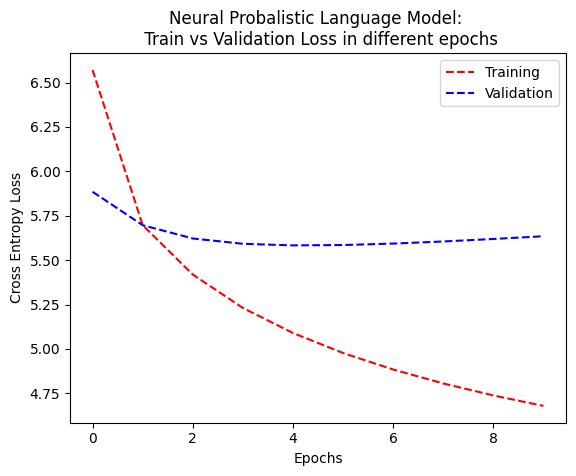

In [52]:
x_axis = range(len(loss_train))
plt.plot(x_axis,loss_train,'r--' , label="Training")
plt.plot(x_axis,loss_val, 'b--', label="Validation")
plt.legend(loc="upper right")
plt.title("Neural Probalistic Language Model: \n Train vs Validation Loss in different epochs")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")